In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!rm -rf /content/pneumonia_data
!unzip -q "/content/drive/MyDrive/images.zip" -d /content/pneumonia_data


Classify as normal, bacterial pneumonia or viral pneumonia

In [ ]:
import os, shutil

def reorganize_dataset(root_dir):
    for split in ['train', 'test', 'val']:
        pneu_dir = os.path.join(root_dir, split, 'PNEUMONIA')
        bacterial_dir = os.path.join(root_dir, split, 'BACTERIAL')
        viral_dir = os.path.join(root_dir, split, 'VIRAL')

        os.makedirs(bacterial_dir, exist_ok=True)
        os.makedirs(viral_dir, exist_ok=True)

        for fname in os.listdir(pneu_dir):
            src = os.path.join(pneu_dir, fname)
            if '_bacteria_' in fname.lower():
                dst = os.path.join(bacterial_dir, fname)
            elif '_virus_' in fname.lower():
                dst = os.path.join(viral_dir, fname)
            else:
                continue
            shutil.move(src, dst)

        if not os.listdir(pneu_dir):
            os.rmdir(pneu_dir)


reorganize_dataset("/content/pneumonia_data/images")

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    '/content/pneumonia_data/images/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_test_gen.flow_from_directory(
    '/content/pneumonia_data/images/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = val_test_gen.flow_from_directory(
    '/content/pneumonia_data/images/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3577 images belonging to 3 classes.
Found 1655 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 3,211,779 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.5804 - loss: 0.9341

112/112 ━━━━━━━━━━━━━━━━━━━━ 118s 941ms/step - accuracy: 0.5811 - loss: 0.9327 - val_accuracy: 0.7625 - val_loss: 0.5784
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.7174 - loss: 0.6452

112/112 ━━━━━━━━━━━━━━━━━━━━ 87s 779ms/step - accuracy: 0.7174 - loss: 0.6450 - val_accuracy: 0.7927 - val_loss: 0.5381
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 141s 772ms/step - accuracy: 0.7356 - loss: 0.5999 - val_accuracy: 0.7819 - val_loss: 0.5693
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7334 - loss: 0.6113

112/112 ━━━━━━━━━━━━━━━━━━━━ 143s 779ms/step - accuracy: 0.7334 - loss: 0.6111 - val_accuracy: 0.8042 - val_loss: 0.5091
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 142s 776ms/step - accuracy: 0.7569 - loss: 0.5654 - val_accuracy: 0.7831 - val_loss: 0.5764
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 92s 823ms/step - accuracy: 0.7652 - loss: 0.5497 - val_accuracy: 0.7915 - val_loss: 0.5414
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7709 - loss: 0.5260

112/112 ━━━━━━━━━━━━━━━━━━━━ 87s 774ms/step - accuracy: 0.7709 - loss: 0.5262 - val_accuracy: 0.8042 - val_loss: 0.5058
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.7681 - loss: 0.5346

112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 793ms/step - accuracy: 0.7681 - loss: 0.5345 - val_accuracy: 0.8079 - val_loss: 0.5039
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 86s 769ms/step - accuracy: 0.7796 - loss: 0.5352 - val_accuracy: 0.8012 - val_loss: 0.5126
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 143s 779ms/step - accuracy: 0.7728 - loss: 0.5130 - val_accuracy: 0.7946 - val_loss: 0.5507
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 87s 778ms/step - accuracy: 0.7847 - loss: 0.5124 - val_accuracy: 0.8018 - val_loss: 0.5157


In [ ]:
test_data = val_test_gen.flow_from_directory(
    '/content/pneumonia_data/images/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 624 images belonging to 3 classes.


In [ ]:
# model.save('/content/drive/MyDrive/new_final.h5')

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/new_sevensix.h5'
model = load_model(model_path)


# Evaluate the model and plot the confusion matrix

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step


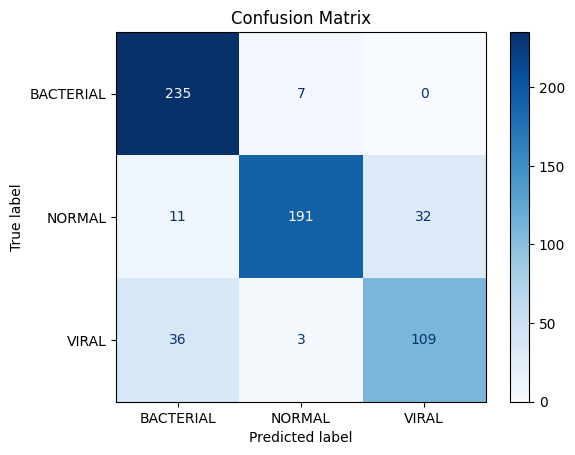


Classification Report:
              precision    recall  f1-score   support

   BACTERIAL       0.83      0.97      0.90       242
      NORMAL       0.95      0.82      0.88       234
       VIRAL       0.77      0.74      0.75       148

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.86      0.86      0.86       624



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = []
y_pred = []


test_data.reset()



predictions = model.predict(test_data, verbose=1)

y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes


class_labels = list(test_data.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))



In [ ]:
!pip install tf-explain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


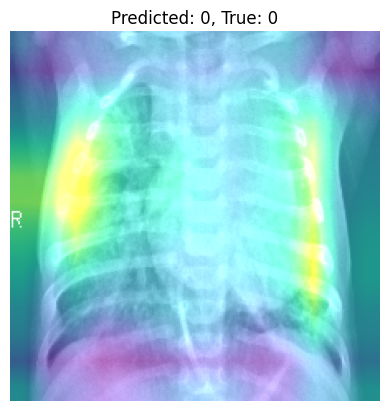

In [ ]:
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt
import numpy as np

# Pick one image from the test set
x_batch, y_batch = next(test_data)
image = x_batch[0:1]  # shape: (1, 224, 224, 3)
true_label = np.argmax(y_batch[0])

# Get prediction
pred = model.predict(image)
predicted_class = np.argmax(pred)

# Run Grad-CAM with target layer specified
explainer = GradCAM()
explanation = explainer.explain(
    validation_data=(image, None),
    model=model,
    class_index=predicted_class,
    layer_name="block5_conv3"  # specify last conv layer in VGG16
)

# Show Grad-CAM result
plt.imshow(explanation)
plt.title(f"Predicted: {predicted_class}, True: {true_label}")
plt.axis('off')
plt.show()



**What You're Seeing:**

Bright/colored regions (yellow/red): Areas the model focused on when making its prediction.

Cooler regions (blue/green): Less important or ignored by the model.

The background is the original X-ray image, but overlaid with this "importance map" as a semi-transparent layer.





